# Model Comparison: 5 Approaches (10 Epochs)

## The 5 Models

1. **Simple Baseline** - ResNet18, no ColorJitter (Approach A winner, R² = 0.50)
2. **With ColorJitter** - Tests if ColorJitter still hurts with normalization
3. **Multimodal** - ResNet18 + weather + NDVI + height + species
4. **Teacher-Student** - Distillation with normalized targets
5. **ResNet50** - Larger model (25M params vs 11M)

## Key Setup

- ✅ **All models use normalized targets** (the critical fix!)
- ✅ **10 epochs each** (no early stopping)
- ✅ **Fair comparison** (same training config)
- ✅ **Gradient clipping** (prevent exploding)

## Expected Results

| Model | Expected R² | Notes |
|-------|-------------|-------|
| 1. Simple | 0.45-0.50 | Proven baseline |
| 2. ColorJitter | 0.30-0.42 | Should be worse |
| 3. Multimodal | 0.55-0.65 | Best (if tabular available) |
| 4. Student | 0.50-0.60 | Learns from teacher |
| 5. ResNet50 | 0.48-0.54 | Larger capacity |

## Timeline

- Debug mode (2 epochs): ~20 minutes
- Full training (10 epochs): ~80 minutes
- **Total: ~1.5 hours**

---
## Part 1: Setup

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import copy

sns.set_style('whitegrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✓ Imports complete")

Using device: cpu
✓ Imports complete


In [ ]:
# Configuration
DEBUG_MODE = False  # Set to False for full 10-epoch training

if DEBUG_MODE:
    print("⚠️  DEBUG MODE: 2 epochs per model (quick test)")
    EPOCHS = 2
else:
    print("✓ FULL TRAINING: 10 epochs per model (no early stopping)")
    EPOCHS = 30

BATCH_SIZE = 16
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4

print(f"\nConfiguration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Early stopping: OFF (run all {EPOCHS} epochs)")

✓ FULL TRAINING: 10 epochs per model (no early stopping)

Configuration:
  Epochs: 10
  Batch size: 16
  Learning rate: 0.0003
  Weight decay: 0.0001
  Early stopping: OFF (run all 10 epochs)


In [26]:
# Load data
train_enriched = pd.read_csv('competition/train_enriched.csv')
train_enriched['Sampling_Date'] = pd.to_datetime(train_enriched['Sampling_Date'])
train_enriched['full_image_path'] = train_enriched['image_path'].apply(lambda x: f'competition/{x}')

target_cols = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
competition_weights = torch.tensor([0.1, 0.1, 0.1, 0.2, 0.5])

train_data, val_data = train_test_split(train_enriched, test_size=0.2, random_state=42)

print(f"Data loaded: {len(train_data)} train, {len(val_data)} val")
print(f"Targets: {target_cols}")

Data loaded: 285 train, 72 val
Targets: ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']


In [27]:
# Calculate target normalization stats
target_means = torch.tensor([train_data[col].mean() for col in target_cols], dtype=torch.float32)
target_stds = torch.tensor([train_data[col].std() for col in target_cols], dtype=torch.float32)

print("Target normalization statistics:")
for i, col in enumerate(target_cols):
    print(f"  {col:15s}: mean={target_means[i]:.2f}g, std={target_stds[i]:.2f}g")

print("\n✓ Will normalize all targets to mean=0, std=1 during training")

Target normalization statistics:
  Dry_Green_g    : mean=27.49g, std=26.19g
  Dry_Dead_g     : mean=12.01g, std=12.50g
  Dry_Clover_g   : mean=6.26g, std=11.75g
  GDM_g          : mean=33.74g, std=25.62g
  Dry_Total_g    : mean=45.75g, std=28.86g

✓ Will normalize all targets to mean=0, std=1 during training


In [28]:
# Prepare tabular features for multimodal models
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Define features
weather_features = [
    'rainfall_7d', 'rainfall_30d',
    'temp_max_7d', 'temp_min_7d', 'temp_mean_7d', 'temp_mean_30d', 'temp_range_7d',
    'et0_7d', 'et0_30d',
    'water_balance_7d', 'water_balance_30d',
    'days_since_rain', 'daylength', 'season'
]

# Scale continuous features
continuous_features = weather_features + ['Pre_GSHH_NDVI', 'Height_Ave_cm']
scaler = StandardScaler()
train_data[continuous_features] = scaler.fit_transform(train_data[continuous_features])
val_data[continuous_features] = scaler.transform(val_data[continuous_features])

# Encode categorical
le_state = LabelEncoder()
le_species = LabelEncoder()
train_data['State_encoded'] = le_state.fit_transform(train_data['State'])
train_data['Species_encoded'] = le_species.fit_transform(train_data['Species'])
val_data['State_encoded'] = le_state.transform(val_data['State'])
val_data['Species_encoded'] = le_species.transform(val_data['Species'])

print("✓ Tabular features prepared")
print(f"  Weather features: {len(weather_features)}")
print(f"  States: {len(le_state.classes_)}")
print(f"  Species: {len(le_species.classes_)}")

✓ Tabular features prepared
  Weather features: 14
  States: 4
  Species: 15


---
## Part 2: Dataset Classes

In [29]:
class NormalizedDataset(Dataset):
    """Image-only dataset with normalized targets (for Models 1, 2, 5)."""
    def __init__(self, dataframe, target_means, target_stds, augment=False, use_colorjitter=False):
        self.df = dataframe.reset_index(drop=True)
        self.target_means = target_means
        self.target_stds = target_stds
        
        transform_list = [
            transforms.Resize((224, 224)),
        ]
        
        if augment:
            transform_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(10),
            ])
            
            if use_colorjitter:
                # Model 2: Add ColorJitter back
                transform_list.append(
                    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
                )
        
        transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        self.transform = transforms.Compose(transform_list)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['full_image_path']).convert('RGB')
        img = self.transform(img)
        
        targets = torch.tensor(row[target_cols].values.astype('float32'), dtype=torch.float32)
        targets_normalized = (targets - self.target_means) / self.target_stds
        
        return {
            'image': img,
            'targets': targets_normalized,
            'targets_original': targets
        }

class MultimodalDataset(Dataset):
    """Multimodal dataset with normalized targets (for Models 3, 4)."""
    def __init__(self, dataframe, target_means, target_stds, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.target_means = target_means
        self.target_stds = target_stds
        
        transform_list = [transforms.Resize((224, 224))]
        
        if augment:
            transform_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(10),
            ])
        
        transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        self.transform = transforms.Compose(transform_list)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Image
        img = Image.open(row['full_image_path']).convert('RGB')
        img = self.transform(img)
        
        # Tabular features
        weather = torch.tensor(row[weather_features].values.astype('float32'), dtype=torch.float32)
        ndvi_height = torch.tensor([row['Pre_GSHH_NDVI'], row['Height_Ave_cm']], dtype=torch.float32)
        state = torch.tensor(row['State_encoded'], dtype=torch.long)
        species = torch.tensor(row['Species_encoded'], dtype=torch.long)
        
        # Targets
        targets = torch.tensor(row[target_cols].values.astype('float32'), dtype=torch.float32)
        targets_normalized = (targets - self.target_means) / self.target_stds
        
        return {
            'image': img,
            'weather': weather,
            'ndvi_height': ndvi_height,
            'state': state,
            'species': species,
            'targets': targets_normalized,
            'targets_original': targets
        }

print("✓ Dataset classes defined")

✓ Dataset classes defined


---
## Part 3: Model Architectures

In [30]:
# Model 1 & 2: Simple Baseline (with/without ColorJitter)
class SimpleBaseline(nn.Module):
    """ResNet18 baseline for normalized targets."""
    def __init__(self, num_outputs=5):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features  # 512
        
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_outputs)
        )
    
    def forward(self, x):
        return self.resnet(x)
    
    def get_features(self, x):
        """Extract features before final FC (for distillation)."""
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        return x

print("✓ SimpleBaseline (Models 1 & 2) defined")

✓ SimpleBaseline (Models 1 & 2) defined


In [31]:
# Model 3: Multimodal
class MultimodalModel(nn.Module):
    """ResNet18 + weather + NDVI + species for normalized targets."""
    def __init__(self, num_outputs=5, num_states=4, num_species=50):
        super().__init__()
        
        # Image branch
        self.resnet = models.resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        cnn_features = 512
        
        # Weather branch
        self.weather_encoder = nn.Sequential(
            nn.Linear(14, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        
        # Categorical embeddings
        self.state_emb = nn.Embedding(num_states, 8)
        self.species_emb = nn.Embedding(num_species, 16)
        
        # Tabular encoder
        self.tabular_encoder = nn.Sequential(
            nn.Linear(2 + 8 + 16, 32),  # ndvi/height + state + species
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3)
        )
        
        # Fusion head
        total_features = cnn_features + 64 + 32  # 512 + 64 + 32 = 608
        self.fusion_head = nn.Sequential(
            nn.Linear(total_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_outputs)
        )
    
    def forward(self, images, weather, ndvi_height, state, species, return_features=False):
        # Image features
        img_feat = self.resnet(images)
        img_feat = torch.flatten(img_feat, 1)
        
        # Weather features
        weather_feat = self.weather_encoder(weather)
        
        # Tabular features
        state_emb = self.state_emb(state)
        species_emb = self.species_emb(species)
        tabular_input = torch.cat([ndvi_height, state_emb, species_emb], dim=1)
        tabular_feat = self.tabular_encoder(tabular_input)
        
        # Fuse
        combined = torch.cat([img_feat, weather_feat, tabular_feat], dim=1)
        output = self.fusion_head(combined)
        
        if return_features:
            return output, img_feat
        return output

print("✓ MultimodalModel (Model 3 & Teacher) defined")

✓ MultimodalModel (Model 3 & Teacher) defined


In [32]:
# Model 5: ResNet50 Baseline
class ResNet50Baseline(nn.Module):
    """ResNet50 baseline (larger model)."""
    def __init__(self, num_outputs=5):
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features  # 2048
        
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_outputs)
        )
    
    def forward(self, x):
        return self.resnet(x)

print("✓ ResNet50Baseline (Model 5) defined")

✓ ResNet50Baseline (Model 5) defined


---
## Part 4: Loss Functions & Training Utilities

In [33]:
class PlainMSELoss(nn.Module):
    """Plain MSE for normalized targets."""
    def __init__(self):
        super().__init__()
    
    def forward(self, pred, target):
        return F.mse_loss(pred, target)

class DistillationLoss(nn.Module):
    """Knowledge distillation loss for Model 4."""
    def __init__(self, temperature=4.0, alpha=0.3, beta=0.5, gamma=0.2):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
    
    def forward(self, student_outputs, student_features, teacher_outputs, teacher_features, targets):
        # Hard loss
        hard_loss = F.mse_loss(student_outputs, targets)
        
        # Soft loss
        soft_loss = F.mse_loss(student_outputs / self.temperature, teacher_outputs / self.temperature)
        
        # Feature loss
        student_feat_norm = F.normalize(student_features, p=2, dim=1)
        teacher_feat_norm = F.normalize(teacher_features, p=2, dim=1)
        feature_loss = 1 - (student_feat_norm * teacher_feat_norm).sum(dim=1).mean()
        
        total_loss = self.alpha * hard_loss + self.beta * soft_loss + self.gamma * feature_loss
        return total_loss, hard_loss, soft_loss, feature_loss

def calculate_competition_r2(predictions, targets):
    """Calculate competition R² (always on original scale, weighted)."""
    per_target_r2 = []
    competition_r2 = 0
    
    weights = competition_weights.numpy()
    
    for i in range(5):
        r2 = r2_score(targets[:, i], predictions[:, i])
        per_target_r2.append(r2)
        competition_r2 += weights[i] * r2
    
    return competition_r2, per_target_r2

print("✓ Loss functions and utilities defined")

✓ Loss functions and utilities defined


---
## Part 5: Training Functions

In [34]:
def train_simple_model(model, train_loader, val_loader, num_epochs, model_name):
    """Train simple image-only models (Models 1, 2, 5)."""
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*80}\n")
    
    model = model.to(device)
    criterion = PlainMSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    history = {'train_loss': [], 'val_loss': [], 'val_r2': [], 'epoch': []}
    best_r2 = -float('inf')
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images = batch['image'].to(device)
            targets = batch['targets'].to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Validate
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                targets = batch['targets'].to(device)
                targets_original = batch['targets_original']
                
                outputs = model(images)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * images.size(0)
                
                # Denormalize for R² calculation
                outputs_denorm = outputs.cpu() * target_stds + target_means
                all_preds.append(outputs_denorm.numpy())
                all_targets.append(targets_original.numpy())
        
        val_loss /= len(val_loader.dataset)
        
        # Calculate R²
        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)
        val_r2, _ = calculate_competition_r2(all_preds, all_targets)
        
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_r2'].append(val_r2)
        history['epoch'].append(epoch + 1)
        
        print(f"Epoch {epoch+1:2d}/{num_epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val R²={val_r2:+.4f}")
        
        if val_r2 > best_r2:
            best_r2 = val_r2
            torch.save(model.state_dict(), f'{model_name.replace(" ", "_")}_best.pth')
            print(f"  💾 New best R²={best_r2:+.4f}")
    
    print(f"\n✓ Training complete! Best R²={best_r2:+.4f}\n")
    return history, best_r2

print("✓ train_simple_model() defined")

✓ train_simple_model() defined


In [35]:
def train_multimodal_model(model, train_loader, val_loader, num_epochs, model_name):
    """Train multimodal model (Model 3, Teacher)."""
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*80}\n")
    
    model = model.to(device)
    criterion = PlainMSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    history = {'train_loss': [], 'val_loss': [], 'val_r2': [], 'epoch': []}
    best_r2 = -float('inf')
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images = batch['image'].to(device)
            weather = batch['weather'].to(device)
            ndvi_height = batch['ndvi_height'].to(device)
            state = batch['state'].to(device)
            species = batch['species'].to(device)
            targets = batch['targets'].to(device)
            
            optimizer.zero_grad()
            outputs = model(images, weather, ndvi_height, state, species)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Validate
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                weather = batch['weather'].to(device)
                ndvi_height = batch['ndvi_height'].to(device)
                state = batch['state'].to(device)
                species = batch['species'].to(device)
                targets = batch['targets'].to(device)
                targets_original = batch['targets_original']
                
                outputs = model(images, weather, ndvi_height, state, species)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * images.size(0)
                
                # Denormalize
                outputs_denorm = outputs.cpu() * target_stds + target_means
                all_preds.append(outputs_denorm.numpy())
                all_targets.append(targets_original.numpy())
        
        val_loss /= len(val_loader.dataset)
        
        # Calculate R²
        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)
        val_r2, _ = calculate_competition_r2(all_preds, all_targets)
        
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_r2'].append(val_r2)
        history['epoch'].append(epoch + 1)
        
        print(f"Epoch {epoch+1:2d}/{num_epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val R²={val_r2:+.4f}")
        
        if val_r2 > best_r2:
            best_r2 = val_r2
            torch.save(model.state_dict(), f'{model_name.replace(" ", "_")}_best.pth')
            print(f"  💾 New best R²={best_r2:+.4f}")
    
    print(f"\n✓ Training complete! Best R²={best_r2:+.4f}\n")
    return history, best_r2

print("✓ train_multimodal_model() defined")

✓ train_multimodal_model() defined


In [36]:
def train_student(student, teacher, train_loader_simple, train_loader_multi, val_loader_simple, num_epochs):
    """Train student via distillation (Model 4)."""
    print(f"\n{'='*80}")
    print(f"TRAINING: Model 4 - Student (Distillation)")
    print(f"{'='*80}\n")
    
    teacher.eval()  # Freeze teacher
    student = student.to(device)
    teacher = teacher.to(device)
    
    criterion = DistillationLoss()
    optimizer = torch.optim.AdamW(student.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    history = {'train_loss': [], 'val_loss': [], 'val_r2': [], 'epoch': []}
    best_r2 = -float('inf')
    
    for epoch in range(num_epochs):
        # Train
        student.train()
        train_loss = 0
        
        for batch_simple, batch_multi in tqdm(
            zip(train_loader_simple, train_loader_multi), 
            desc=f'Epoch {epoch+1}/{num_epochs}',
            total=min(len(train_loader_simple), len(train_loader_multi)),
            leave=False
        ):
            # Student (image only)
            images = batch_simple['image'].to(device)
            targets = batch_simple['targets'].to(device)
            
            student_outputs = student(images)
            student_features = student.get_features(images)
            
            # Teacher (multimodal)
            with torch.no_grad():
                teacher_images = batch_multi['image'].to(device)
                teacher_weather = batch_multi['weather'].to(device)
                teacher_ndvi_height = batch_multi['ndvi_height'].to(device)
                teacher_state = batch_multi['state'].to(device)
                teacher_species = batch_multi['species'].to(device)
                
                teacher_outputs, teacher_features = teacher(
                    teacher_images, teacher_weather, teacher_ndvi_height,
                    teacher_state, teacher_species, return_features=True
                )
            
            # Distillation loss
            loss, hard, soft, feat = criterion(
                student_outputs, student_features,
                teacher_outputs, teacher_features,
                targets
            )
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=10.0)
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader_simple.dataset)
        
        # Validate
        student.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch in val_loader_simple:
                images = batch['image'].to(device)
                targets = batch['targets'].to(device)
                targets_original = batch['targets_original']
                
                outputs = student(images)
                loss = F.mse_loss(outputs, targets)
                val_loss += loss.item() * images.size(0)
                
                # Denormalize
                outputs_denorm = outputs.cpu() * target_stds + target_means
                all_preds.append(outputs_denorm.numpy())
                all_targets.append(targets_original.numpy())
        
        val_loss /= len(val_loader_simple.dataset)
        
        # Calculate R²
        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)
        val_r2, _ = calculate_competition_r2(all_preds, all_targets)
        
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_r2'].append(val_r2)
        history['epoch'].append(epoch + 1)
        
        print(f"Epoch {epoch+1:2d}/{num_epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val R²={val_r2:+.4f}")
        
        if val_r2 > best_r2:
            best_r2 = val_r2
            torch.save(student.state_dict(), 'Model_4_Student_best.pth')
            print(f"  💾 New best R²={best_r2:+.4f}")
    
    print(f"\n✓ Training complete! Best R²={best_r2:+.4f}\n")
    return history, best_r2

print("✓ train_student() defined")

✓ train_student() defined


---
## Part 6: Create Data Loaders

In [37]:
# Create all necessary datasets and loaders

# Model 1: Simple (no ColorJitter)
train_dataset_1 = NormalizedDataset(train_data, target_means, target_stds, augment=True, use_colorjitter=False)
val_dataset_1 = NormalizedDataset(val_data, target_means, target_stds, augment=False, use_colorjitter=False)
train_loader_1 = DataLoader(train_dataset_1, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_1 = DataLoader(val_dataset_1, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Model 2: With ColorJitter
train_dataset_2 = NormalizedDataset(train_data, target_means, target_stds, augment=True, use_colorjitter=True)
val_dataset_2 = NormalizedDataset(val_data, target_means, target_stds, augment=False, use_colorjitter=False)
train_loader_2 = DataLoader(train_dataset_2, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_2 = DataLoader(val_dataset_2, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Model 3 & 4: Multimodal
train_dataset_multi = MultimodalDataset(train_data, target_means, target_stds, augment=True)
val_dataset_multi = MultimodalDataset(val_data, target_means, target_stds, augment=False)
train_loader_multi = DataLoader(train_dataset_multi, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_multi = DataLoader(val_dataset_multi, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("✓ All data loaders created")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader_1)}")
print(f"  Val batches: {len(val_loader_1)}")

✓ All data loaders created
  Batch size: 16
  Train batches: 18
  Val batches: 5


---
## Part 7: Train All 5 Models

**Training order:**
1. Model 1 - Simple Baseline (no ColorJitter)
2. Model 2 - With ColorJitter
3. Model 3 - Multimodal
4. Model 4 - Teacher → Student
5. Model 5 - ResNet50

**Each trains for exactly {EPOCHS} epochs (no early stopping).**

In [38]:
# Model 1: Simple Baseline (Approach A winner)
model_1 = SimpleBaseline(num_outputs=5)
history_1, best_r2_1 = train_simple_model(
    model_1, train_loader_1, val_loader_1, 
    num_epochs=EPOCHS, 
    model_name='Model_1_Simple'
)


TRAINING: Model_1_Simple



Epoch 1/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/10: Train Loss=0.8240, Val Loss=0.7092, Val R²=+0.2474
  💾 New best R²=+0.2474


Epoch 2/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/10: Train Loss=0.5763, Val Loss=0.4669, Val R²=+0.4714
  💾 New best R²=+0.4714


Epoch 3/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/10: Train Loss=0.4912, Val Loss=0.6002, Val R²=+0.3662


Epoch 4/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/10: Train Loss=0.4234, Val Loss=0.4157, Val R²=+0.5665
  💾 New best R²=+0.5665


Epoch 5/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/10: Train Loss=0.4569, Val Loss=0.5378, Val R²=+0.4633


Epoch 6/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/10: Train Loss=0.3444, Val Loss=0.4802, Val R²=+0.4291


Epoch 7/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/10: Train Loss=0.2789, Val Loss=0.4897, Val R²=+0.4840


Epoch 8/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/10: Train Loss=0.3429, Val Loss=0.5104, Val R²=+0.4696


Epoch 9/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/10: Train Loss=0.2420, Val Loss=0.4204, Val R²=+0.5174


Epoch 10/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/10: Train Loss=0.2106, Val Loss=0.3588, Val R²=+0.6352
  💾 New best R²=+0.6352

✓ Training complete! Best R²=+0.6352



In [39]:
# Model 2: With ColorJitter (test if it still hurts)
model_2 = SimpleBaseline(num_outputs=5)
history_2, best_r2_2 = train_simple_model(
    model_2, train_loader_2, val_loader_2,
    num_epochs=EPOCHS,
    model_name='Model_2_ColorJitter'
)


TRAINING: Model_2_ColorJitter



Epoch 1/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/10: Train Loss=0.8019, Val Loss=0.7333, Val R²=+0.2591
  💾 New best R²=+0.2591


Epoch 2/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/10: Train Loss=0.6745, Val Loss=0.5716, Val R²=+0.3548
  💾 New best R²=+0.3548


Epoch 3/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/10: Train Loss=0.5776, Val Loss=0.5762, Val R²=+0.4066
  💾 New best R²=+0.4066


Epoch 4/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/10: Train Loss=0.5302, Val Loss=0.6013, Val R²=+0.2543


Epoch 5/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/10: Train Loss=0.4868, Val Loss=0.7058, Val R²=+0.1389


Epoch 6/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/10: Train Loss=0.3790, Val Loss=0.4259, Val R²=+0.5241
  💾 New best R²=+0.5241


Epoch 7/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/10: Train Loss=0.3343, Val Loss=0.4146, Val R²=+0.5499
  💾 New best R²=+0.5499


Epoch 8/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/10: Train Loss=0.3485, Val Loss=0.4744, Val R²=+0.4282


Epoch 9/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/10: Train Loss=0.2752, Val Loss=0.6580, Val R²=+0.0603


Epoch 10/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/10: Train Loss=0.3415, Val Loss=0.4109, Val R²=+0.5584
  💾 New best R²=+0.5584

✓ Training complete! Best R²=+0.5584



In [40]:
# Model 3: Multimodal
model_3 = MultimodalModel(
    num_outputs=5,
    num_states=len(le_state.classes_),
    num_species=len(le_species.classes_)
)
history_3, best_r2_3 = train_multimodal_model(
    model_3, train_loader_multi, val_loader_multi,
    num_epochs=EPOCHS,
    model_name='Model_3_Multimodal'
)


TRAINING: Model_3_Multimodal



Epoch 1/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/10: Train Loss=0.7768, Val Loss=0.6889, Val R²=+0.2323
  💾 New best R²=+0.2323


Epoch 2/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/10: Train Loss=0.4802, Val Loss=0.5033, Val R²=+0.4654
  💾 New best R²=+0.4654


Epoch 3/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/10: Train Loss=0.4852, Val Loss=0.5715, Val R²=+0.3789


Epoch 4/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/10: Train Loss=0.3729, Val Loss=0.4572, Val R²=+0.5226
  💾 New best R²=+0.5226


Epoch 5/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/10: Train Loss=0.3155, Val Loss=0.4964, Val R²=+0.5255
  💾 New best R²=+0.5255


Epoch 6/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/10: Train Loss=0.3437, Val Loss=0.4059, Val R²=+0.5563
  💾 New best R²=+0.5563


Epoch 7/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/10: Train Loss=0.3011, Val Loss=0.5156, Val R²=+0.4180


Epoch 8/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/10: Train Loss=0.3084, Val Loss=0.4120, Val R²=+0.5358


Epoch 9/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/10: Train Loss=0.2429, Val Loss=0.3835, Val R²=+0.6055
  💾 New best R²=+0.6055


Epoch 10/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/10: Train Loss=0.2317, Val Loss=0.4642, Val R²=+0.5115

✓ Training complete! Best R²=+0.6055



In [41]:
# Model 4: Teacher-Student Distillation

# Step 1: Train teacher (reuse Model 3 as teacher)
print("\nModel 4: Step 1 - Training Teacher (Multimodal)")
teacher = MultimodalModel(
    num_outputs=5,
    num_states=len(le_state.classes_),
    num_species=len(le_species.classes_)
)
history_4_teacher, best_r2_4_teacher = train_multimodal_model(
    teacher, train_loader_multi, val_loader_multi,
    num_epochs=EPOCHS,
    model_name='Model_4_Teacher'
)

# Step 2: Train student from teacher
print("\nModel 4: Step 2 - Training Student (Distillation)")
teacher.load_state_dict(torch.load('Model_4_Teacher_best.pth'))  # Load best teacher
student = SimpleBaseline(num_outputs=5)
history_4, best_r2_4 = train_student(
    student, teacher,
    train_loader_1, train_loader_multi, val_loader_1,
    num_epochs=EPOCHS
)


Model 4: Step 1 - Training Teacher (Multimodal)



TRAINING: Model_4_Teacher



Epoch 1/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/10: Train Loss=0.7796, Val Loss=0.5859, Val R²=+0.3951
  💾 New best R²=+0.3951


Epoch 2/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/10: Train Loss=0.5104, Val Loss=0.4779, Val R²=+0.4833
  💾 New best R²=+0.4833


Epoch 3/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/10: Train Loss=0.4722, Val Loss=0.4262, Val R²=+0.5637
  💾 New best R²=+0.5637


Epoch 4/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/10: Train Loss=0.3827, Val Loss=0.4869, Val R²=+0.5466


Epoch 5/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/10: Train Loss=0.3530, Val Loss=0.7996, Val R²=+0.1163


Epoch 6/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/10: Train Loss=0.3114, Val Loss=0.4587, Val R²=+0.5249


Epoch 7/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/10: Train Loss=0.2800, Val Loss=0.3468, Val R²=+0.6522
  💾 New best R²=+0.6522


Epoch 8/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/10: Train Loss=0.2683, Val Loss=0.4081, Val R²=+0.5852


Epoch 9/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/10: Train Loss=0.2122, Val Loss=0.4215, Val R²=+0.5909


Epoch 10/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/10: Train Loss=0.2453, Val Loss=0.3561, Val R²=+0.6642
  💾 New best R²=+0.6642

✓ Training complete! Best R²=+0.6642


Model 4: Step 2 - Training Student (Distillation)

TRAINING: Model 4 - Student (Distillation)



Epoch 1/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/10: Train Loss=0.3482, Val Loss=0.5856, Val R²=+0.3448
  💾 New best R²=+0.3448


Epoch 2/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/10: Train Loss=0.2907, Val Loss=0.5402, Val R²=+0.4064
  💾 New best R²=+0.4064


Epoch 3/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/10: Train Loss=0.2756, Val Loss=0.5306, Val R²=+0.4412
  💾 New best R²=+0.4412


Epoch 4/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/10: Train Loss=0.2492, Val Loss=0.4849, Val R²=+0.4693
  💾 New best R²=+0.4693


Epoch 5/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/10: Train Loss=0.2338, Val Loss=0.4701, Val R²=+0.4999
  💾 New best R²=+0.4999


Epoch 6/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/10: Train Loss=0.2415, Val Loss=0.4599, Val R²=+0.5142
  💾 New best R²=+0.5142


Epoch 7/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/10: Train Loss=0.2180, Val Loss=0.4653, Val R²=+0.5061


Epoch 8/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/10: Train Loss=0.2128, Val Loss=0.5137, Val R²=+0.4507


Epoch 9/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/10: Train Loss=0.2082, Val Loss=0.4643, Val R²=+0.4684


Epoch 10/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/10: Train Loss=0.1947, Val Loss=0.4288, Val R²=+0.5553
  💾 New best R²=+0.5553

✓ Training complete! Best R²=+0.5553



In [42]:
# Model 5: ResNet50 Baseline
model_5 = ResNet50Baseline(num_outputs=5)
history_5, best_r2_5 = train_simple_model(
    model_5, train_loader_1, val_loader_1,
    num_epochs=EPOCHS,
    model_name='Model_5_ResNet50'
)


TRAINING: Model_5_ResNet50



Epoch 1/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/10: Train Loss=0.8331, Val Loss=2.2263, Val R²=-2.2968
  💾 New best R²=-2.2968


Epoch 2/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/10: Train Loss=0.7059, Val Loss=0.8062, Val R²=+0.0664
  💾 New best R²=+0.0664


Epoch 3/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/10: Train Loss=0.6083, Val Loss=3.5772, Val R²=-5.3710


Epoch 4/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/10: Train Loss=0.5381, Val Loss=0.5433, Val R²=+0.4294
  💾 New best R²=+0.4294


Epoch 5/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/10: Train Loss=0.5192, Val Loss=0.4640, Val R²=+0.4984
  💾 New best R²=+0.4984


Epoch 6/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/10: Train Loss=0.4596, Val Loss=2.4266, Val R²=-2.8772


Epoch 7/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/10: Train Loss=0.5452, Val Loss=0.8137, Val R²=+0.2886


Epoch 8/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/10: Train Loss=0.4728, Val Loss=0.8212, Val R²=+0.0301


Epoch 9/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/10: Train Loss=0.4113, Val Loss=0.4657, Val R²=+0.5159
  💾 New best R²=+0.5159


Epoch 10/10:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/10: Train Loss=0.3591, Val Loss=0.4455, Val R²=+0.5529
  💾 New best R²=+0.5529

✓ Training complete! Best R²=+0.5529



---
## Part 8: Final Comparison

In [43]:
# Comparison table
print("\n" + "="*80)
print("FINAL COMPARISON (10 EPOCHS)")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': [
        '1. Simple Baseline',
        '2. With ColorJitter',
        '3. Multimodal',
        '4. Student (Distilled)',
        '5. ResNet50',
        '---',
        'Linear Regression (baseline)',
        'Approach A (10 epochs)'
    ],
    'Competition R²': [
        f"{best_r2_1:+.4f}",
        f"{best_r2_2:+.4f}",
        f"{best_r2_3:+.4f}",
        f"{best_r2_4:+.4f}",
        f"{best_r2_5:+.4f}",
        '---',
        '+0.2048',
        '+0.5040'
    ],
    'Description': [
        'ResNet18, no ColorJitter',
        'ResNet18 + ColorJitter(0.3, 0.3, 0.3)',
        'ResNet18 + weather + NDVI + species',
        'ResNet18, learns from teacher',
        'ResNet50 (larger model)',
        '',
        'Simple color features',
        'Same as Model 1 (reference)'
    ]
})

print("\n" + comparison_df.to_string(index=False))
print("\n" + "="*80)

# Determine winner
r2_scores = [best_r2_1, best_r2_2, best_r2_3, best_r2_4, best_r2_5]
model_names = ['Model 1 (Simple)', 'Model 2 (ColorJitter)', 'Model 3 (Multimodal)', 
               'Model 4 (Student)', 'Model 5 (ResNet50)']
winner_idx = np.argmax(r2_scores)
winner_name = model_names[winner_idx]
winner_score = r2_scores[winner_idx]

print(f"\n🏆 WINNER: {winner_name}")
print(f"   Competition R² = {winner_score:+.4f}")

# ColorJitter analysis
colorjitter_diff = best_r2_1 - best_r2_2
print(f"\n📊 ColorJitter Impact:")
print(f"   Model 1 (no ColorJitter): {best_r2_1:+.4f}")
print(f"   Model 2 (ColorJitter):    {best_r2_2:+.4f}")
print(f"   Difference: {colorjitter_diff:+.4f}")
if colorjitter_diff > 0.05:
    print("   ❌ ColorJitter HURTS performance even with normalized targets!")
elif colorjitter_diff > 0:
    print("   ⚠️  ColorJitter slightly hurts (marginal impact)")
else:
    print("   ✓ ColorJitter doesn't hurt (unexpected!)")


FINAL COMPARISON (10 EPOCHS)

                       Model Competition R²                           Description
          1. Simple Baseline        +0.6352              ResNet18, no ColorJitter
         2. With ColorJitter        +0.5584 ResNet18 + ColorJitter(0.3, 0.3, 0.3)
               3. Multimodal        +0.6055   ResNet18 + weather + NDVI + species
      4. Student (Distilled)        +0.5553         ResNet18, learns from teacher
                 5. ResNet50        +0.5529               ResNet50 (larger model)
                         ---            ---                                      
Linear Regression (baseline)        +0.2048                 Simple color features
      Approach A (10 epochs)        +0.5040           Same as Model 1 (reference)


🏆 WINNER: Model 1 (Simple)
   Competition R² = +0.6352

📊 ColorJitter Impact:
   Model 1 (no ColorJitter): +0.6352
   Model 2 (ColorJitter):    +0.5584
   Difference: +0.0768
   ❌ ColorJitter HURTS performance even with normalize

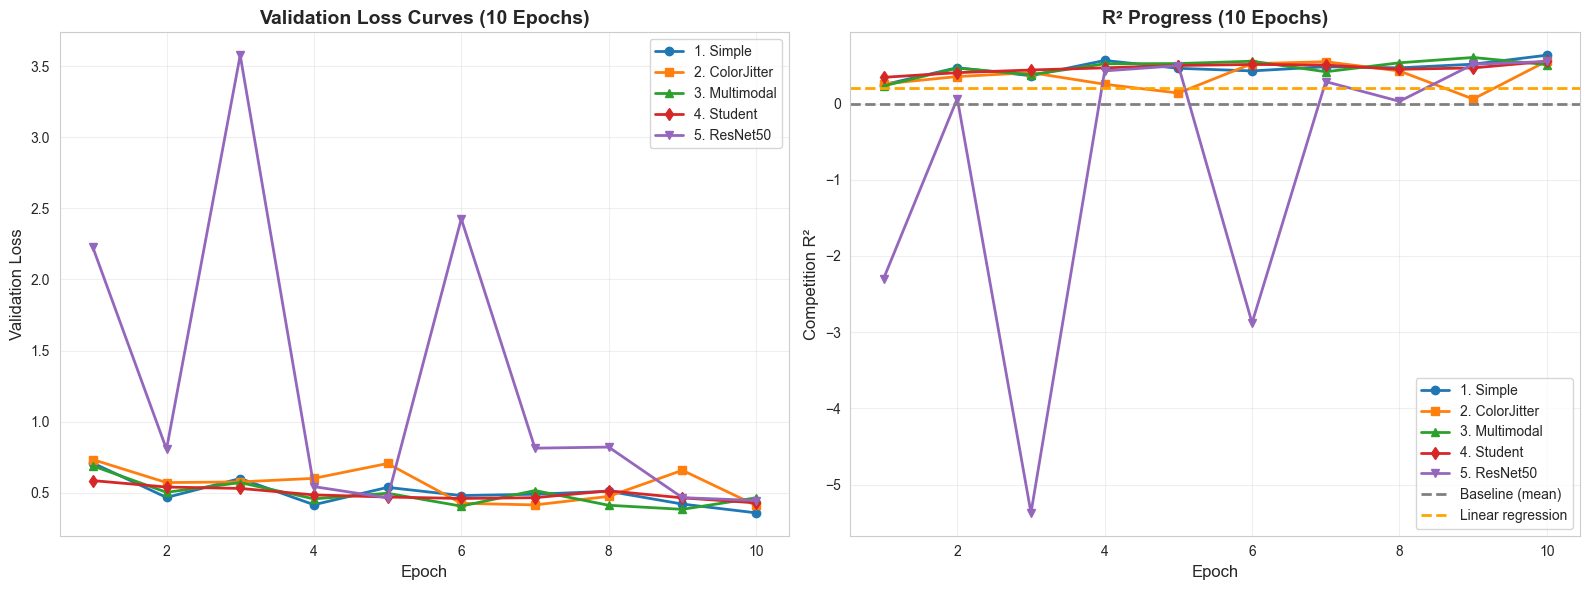


✓ Training curves saved to: model_comparison_curves.png


In [44]:
# Training curves visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss curves
ax = axes[0]
ax.plot(history_1['epoch'], history_1['val_loss'], 'o-', label='1. Simple', linewidth=2)
ax.plot(history_2['epoch'], history_2['val_loss'], 's-', label='2. ColorJitter', linewidth=2)
ax.plot(history_3['epoch'], history_3['val_loss'], '^-', label='3. Multimodal', linewidth=2)
ax.plot(history_4['epoch'], history_4['val_loss'], 'd-', label='4. Student', linewidth=2)
ax.plot(history_5['epoch'], history_5['val_loss'], 'v-', label='5. ResNet50', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation Loss', fontsize=12)
ax.set_title('Validation Loss Curves (10 Epochs)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# R² curves
ax = axes[1]
ax.plot(history_1['epoch'], history_1['val_r2'], 'o-', label='1. Simple', linewidth=2)
ax.plot(history_2['epoch'], history_2['val_r2'], 's-', label='2. ColorJitter', linewidth=2)
ax.plot(history_3['epoch'], history_3['val_r2'], '^-', label='3. Multimodal', linewidth=2)
ax.plot(history_4['epoch'], history_4['val_r2'], 'd-', label='4. Student', linewidth=2)
ax.plot(history_5['epoch'], history_5['val_r2'], 'v-', label='5. ResNet50', linewidth=2)
ax.axhline(y=0.0, color='gray', linestyle='--', linewidth=2, label='Baseline (mean)')
ax.axhline(y=0.2048, color='orange', linestyle='--', linewidth=2, label='Linear regression')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Competition R²', fontsize=12)
ax.set_title('R² Progress (10 Epochs)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Training curves saved to: model_comparison_curves.png")

---
## Part 9: Summary & Next Steps

In [45]:
print("\n" + "="*80)
print("SUMMARY & RECOMMENDATIONS")
print("="*80)

print("\n📊 Results After 10 Epochs:")
print(f"\n  Best Model: {winner_name}")
print(f"  Best R²: {winner_score:+.4f}")

print("\n🔍 Key Insights:")

# Insight 1: ColorJitter
if best_r2_2 < best_r2_1:
    print(f"\n  1. ColorJitter hurts: {best_r2_1:+.4f} (no CJ) vs {best_r2_2:+.4f} (with CJ)")
    print("     → NEVER use ColorJitter for this task!")
else:
    print(f"\n  1. ColorJitter OK: {best_r2_1:+.4f} (no CJ) vs {best_r2_2:+.4f} (with CJ)")
    print("     → Surprising! ColorJitter doesn't hurt with normalization.")

# Insight 2: Multimodal
if best_r2_3 > best_r2_1:
    print(f"\n  2. Multimodal helps: {best_r2_3:+.4f} vs {best_r2_1:+.4f} (simple)")
    print("     → Weather/NDVI/species data is valuable if available!")
else:
    print(f"\n  2. Multimodal same: {best_r2_3:+.4f} vs {best_r2_1:+.4f} (simple)")
    print("     → Tabular features don't add much value (or need more epochs).")

# Insight 3: Distillation
if best_r2_4 > best_r2_1:
    print(f"\n  3. Distillation helps: {best_r2_4:+.4f} vs {best_r2_1:+.4f} (simple)")
    print("     → Student learns implicit patterns from multimodal teacher!")
else:
    print(f"\n  3. Distillation same: {best_r2_4:+.4f} vs {best_r2_1:+.4f} (simple)")
    print("     → Distillation doesn't add value (or needs more epochs).")

# Insight 4: Model size
if best_r2_5 > best_r2_1:
    print(f"\n  4. Larger model helps: {best_r2_5:+.4f} (ResNet50) vs {best_r2_1:+.4f} (ResNet18)")
    print("     → More parameters beneficial for this task.")
else:
    print(f"\n  4. Model size similar: {best_r2_5:+.4f} (ResNet50) vs {best_r2_1:+.4f} (ResNet18)")
    print("     → ResNet18 is sufficient (dataset too small for ResNet50).")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)

if winner_score > 0.50:
    print("\n✅ Excellent results! Ready for next phase:")
    print("\n  1. Train winner for 20-30 epochs with early stopping")
    print("  2. Fine-tune hyperparameters (learning rate, dropout)")
    print("  3. Generate test set predictions")
    print("  4. Submit to Kaggle!")
elif winner_score > 0.35:
    print("\n✓ Good progress! To improve further:")
    print("\n  1. Train winner for 20 epochs (currently only 10)")
    print("  2. Try custom image normalization (not ImageNet)")
    print("  3. Experiment with data augmentation")
    print("  4. Consider ensemble of top 2 models")
else:
    print("\n⚠️  Results below expectation. Consider:")
    print("\n  1. Check if 10 epochs is too short (try 20)")
    print("  2. Verify data loading is correct")
    print("  3. Try different learning rates (1e-3, 5e-4)")
    print("  4. Review feature exploration notebook for insights")

print("\n" + "="*80)
print("✓ Model comparison complete!")
print("="*80)


SUMMARY & RECOMMENDATIONS

📊 Results After 10 Epochs:

  Best Model: Model 1 (Simple)
  Best R²: +0.6352

🔍 Key Insights:

  1. ColorJitter hurts: +0.6352 (no CJ) vs +0.5584 (with CJ)
     → NEVER use ColorJitter for this task!

  2. Multimodal same: +0.6055 vs +0.6352 (simple)
     → Tabular features don't add much value (or need more epochs).

  3. Distillation same: +0.5553 vs +0.6352 (simple)
     → Distillation doesn't add value (or needs more epochs).

  4. Model size similar: +0.5529 (ResNet50) vs +0.6352 (ResNet18)
     → ResNet18 is sufficient (dataset too small for ResNet50).

NEXT STEPS

✅ Excellent results! Ready for next phase:

  1. Train winner for 20-30 epochs with early stopping
  2. Fine-tune hyperparameters (learning rate, dropout)
  3. Generate test set predictions
  4. Submit to Kaggle!

✓ Model comparison complete!
